# Predicting sales for Rossmann stores 

## About Rossmann
[Dirk Rossmann GmbH](https://en.wikipedia.org/wiki/Rossmann_(company)), know just as [Rossmann](https://www.rossmann.de/) is one of the largest drug store chains in Europe with around 56,200 employees and more than 4000 stores across Europe. In 2019 Rossmann had more than €10 billion turnover in Germany, Poland, Hungary, the Czech Republic, Turkey, Albania, Kosovo and Spain. 

Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.


## The data
The dataset contains historical sales data for 1,115 Rossmann stores. It should be noted that some stores in the dataset were temporarily closed for refurbishment. And this is made of three csv files:

*  `store.csv`
['Store', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

*  `train.csv`
['Date', 'Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 'SchoolHoliday']

* `holdout.csv` 
The test dataset, and it has the same format as the train.csv

In the following table we can see the features present in dataset, and their meaning.

|Feature | Description|
|---|-------------------------------------------------------------------|
|Id |  an Id that represents a (Store, Date) duple within the test set |
|Store | a unique Id for each store |
|Sales | the turnover for any given day (this is what you are predicting) |
|Customers | the number of customers on a given day |
|Open | an indicator for whether the store was open: 0 = closed, 1 = open | 
|StateHoliday | indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None |
|SchoolHoliday | indicates if the (Store, Date) was affected by the closure of public schools |
|StoreType | differentiates between 4 different store models: a, b, c, d |
|Assortment | describes an assortment level: a = basic, b = extra, c = extended |
|CompetitionDistance | distance in meters to the nearest competitor store |
|CompetitionOpenSince[Month/Year] | gives the approximate year and month of the time the nearest competitor was opened |
|Promo | indicates whether a store is running a promo on that day |
|Promo2 | Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating |
|Promo2Since[Year/Week] | describes the year and calendar week when the store started participating in Promo2 |
|PromoInterval | describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store |



In [1]:
# importing libraries
import datetime as dt
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import seaborn as sns

In [2]:
# loading datasets
rossman_train = pd.read_csv("data/train.csv", low_memory=False)
rossman_stores = pd.read_csv("data/store.csv", low_memory=False)

In [3]:
# show all the columns when using method df.head()
pd.set_option('display.max_columns',50)

# Get to know to the data

Before being able to predict sales we must get know to the data, and that is the purpose of this notebook. 

First we'll explore the train dataset and the store dataset separately. Then we'll merge them and explore it again.

## Train dataset

Let's examine `train.csv`

In [4]:
# train dimensions
print('Dimensions of train.csv:')
print(f' Number of rows: {rossman_train.shape[0]}')
print(f' Number of columns: {rossman_train.shape[1]}')
print()

Dimensions of train.csv:
 Number of rows: 637774
 Number of columns: 9



In [5]:
# column names 
list(rossman_train.columns)

['Date',
 'Store',
 'DayOfWeek',
 'Sales',
 'Customers',
 'Open',
 'Promo',
 'StateHoliday',
 'SchoolHoliday']

In [6]:
# examine first lines of train
rossman_train.head(3)

,Date,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,2013-01-01,1115.0,2.0,0.0,0.0,0.0,0.0,a,1.0
1,2013-01-01,379.0,2.0,0.0,0.0,0.0,0.0,a,1.0
2,2013-01-01,378.0,2.0,0.0,0.0,0.0,0.0,a,1.0


In [7]:
# convert object column to datetime format    
rossman_train['Date'] = pd.to_datetime(rossman_train['Date']) 

In [8]:
# show some descriptive statistics
rossman_train.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,618473.000000,618757.000000,618747.000000,618683.000000,618588.000000,618580.000000,618437.000000
mean,558.105623,3.994914,5668.015834,628.909831,0.829167,0.370447,0.173253
std,321.885545,1.997485,3809.655137,463.786905,0.376363,0.482925,0.378466
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,279.000000,2.000000,3640.000000,397.000000,1.000000,0.000000,0.000000
50%,558.000000,4.000000,5625.000000,604.000000,1.000000,0.000000,0.000000
75%,837.000000,6.000000,7714.000000,833.000000,1.000000,1.000000,0.000000
max,1115.000000,7.000000,38037.000000,7388.000000,1.000000,1.000000,1.000000


In [9]:
# show general info
rossman_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 637774 entries, 0 to 637773
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           637774 non-null  datetime64[ns]
 1   Store          618473 non-null  float64       
 2   DayOfWeek      618757 non-null  float64       
 3   Sales          618747 non-null  float64       
 4   Customers      618683 non-null  float64       
 5   Open           618588 non-null  float64       
 6   Promo          618580 non-null  float64       
 7   StateHoliday   618520 non-null  object        
 8   SchoolHoliday  618437 non-null  float64       
dtypes: datetime64[ns](1), float64(7), object(1)
memory usage: 43.8+ MB


In [10]:
# separate numeric from categorical data
numeric_data = rossman_train.select_dtypes(include=[np.number])
categorical_data = rossman_train.select_dtypes(exclude=[np.number])

print(f' Number of numeric features: {numeric_data.shape[1]}\n Number of categorical features: {categorical_data.shape[1]}')

 Number of numeric features: 7
 Number of categorical features: 2


In [11]:
# show unique values
for col in rossman_train.columns:
    print(f'{col: >21}: {rossman_train[col].nunique()}') 

                 Date: 577
                Store: 1115
            DayOfWeek: 7
                Sales: 19953
            Customers: 3867
                 Open: 2
                Promo: 2
         StateHoliday: 4
        SchoolHoliday: 2


In [12]:
# total number of null values if they are present
print('Features with missing values:\n')
rossman_train.isnull().sum()[rossman_train.isnull().sum() > 0]

Features with missing values:



Store            19301
DayOfWeek        19017
Sales            19027
Customers        19091
Open             19186
Promo            19194
StateHoliday     19254
SchoolHoliday    19337
dtype: int64

As we can see, the dataset has some missing values. We can also visualize these missing values, in a more intuitive way, using the library `missingno`.

In the plot generated using `missingno` the white lines represent mising values.

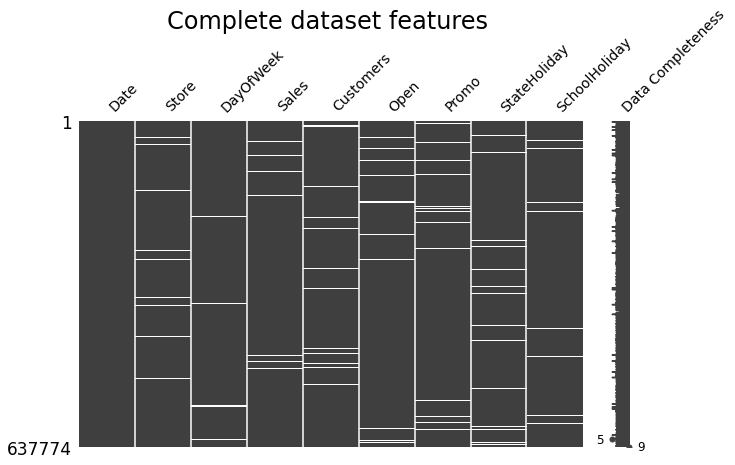

In [13]:
# visualize missing value matrix for the complete dataset
msno.matrix(rossman_train, labels=True, fontsize=14, figsize=(10,6))
plt.title("Complete dataset features ", fontsize=24)
plt.show()

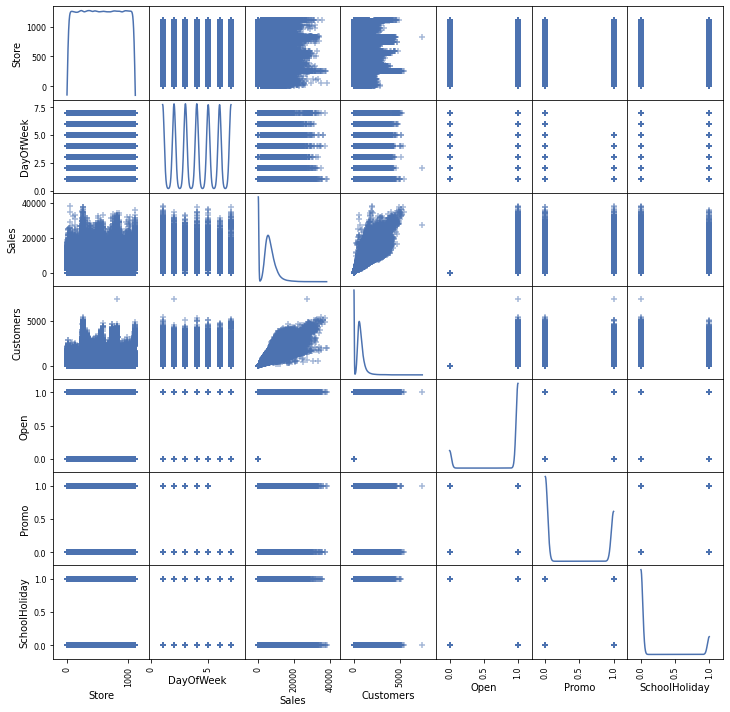

In [14]:
# visualize the dataset
plt.style.use('seaborn-deep')
scatter_matrix(rossman_train, diagonal='kde', range_padding=0.4, marker='+', figsize=(12,12))
plt.show()

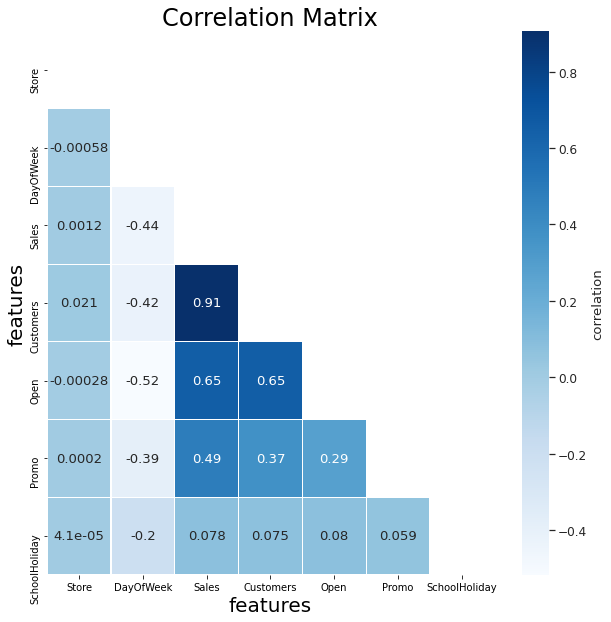

In [15]:
# Correlation matrix completely ignores any non-numeric column. 
fig, ax = plt.subplots(figsize=(10,10))

matrix = np.triu(rossman_train.corr('spearman'))
sns.set(font_scale=1.1)
sns.heatmap(rossman_train.corr(method='spearman'), linewidth= 0.1, annot=True, cmap='Blues', cbar_kws={'label': 'correlation'}, mask=matrix)
plt.xlabel("features", size=20)
plt.ylabel("features", size=20)
plt.title("Correlation Matrix", size=24)
plt.show()

As we can observe from the previous plot, as one could expect, the Customers have a high correlation with the Sales.

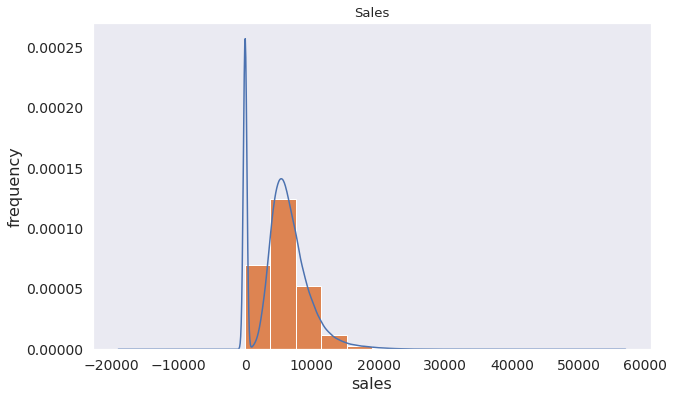

In [16]:
# distribution of sales
fig, ax = plt.subplots(figsize=(10,6))

dist = rossman_train['Sales']
dist.plot.kde(ax=ax, legend=False, title='Sales')
dist.plot.hist(density=True, ax=ax, fontsize=14)
ax.set_ylabel('frequency',size=16)
ax.set_xlabel('sales', size=16)
plt.grid()

plt.show()

## Store dataset

Let's examine `store.csv`

In [17]:
# store dimensions
print('Dimensions of store.csv:')
print(f' Number of rows: {rossman_stores.shape[0]}')
print(f' Number of columns: {rossman_stores.shape[1]}')

Dimensions of store.csv:
 Number of rows: 1115
 Number of columns: 10


In [18]:
# column names 
list(rossman_stores.columns)

['Store',
 'StoreType',
 'Assortment',
 'CompetitionDistance',
 'CompetitionOpenSinceMonth',
 'CompetitionOpenSinceYear',
 'Promo2',
 'Promo2SinceWeek',
 'Promo2SinceYear',
 'PromoInterval']

In [19]:
# examine first lines of store
rossman_stores.head(3)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"


In [20]:
# show some descriptive statistics
rossman_stores.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


In [21]:
# show general info
rossman_stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [22]:
# separate numeric from categorical data
numeric_data = rossman_stores.select_dtypes(include=[np.number])
categorical_data = rossman_stores.select_dtypes(exclude=[np.number])

print(f' Number of numeric features: {numeric_data.shape[1]}\n Number of categorical features: {categorical_data.shape[1]}')

 Number of numeric features: 7
 Number of categorical features: 3


In [23]:
# show unique values
for col in rossman_stores.columns:
    print(f'{col: >21}: {rossman_stores[col].nunique()}') 

                Store: 1115
            StoreType: 4
           Assortment: 3
  CompetitionDistance: 654
CompetitionOpenSinceMonth: 12
CompetitionOpenSinceYear: 23
               Promo2: 2
      Promo2SinceWeek: 24
      Promo2SinceYear: 7
        PromoInterval: 3


In [24]:
# total number of null values if they are present
print('Features with missing values:\n')
rossman_stores.isnull().sum()[rossman_stores.isnull().sum() > 0]

Features with missing values:



CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

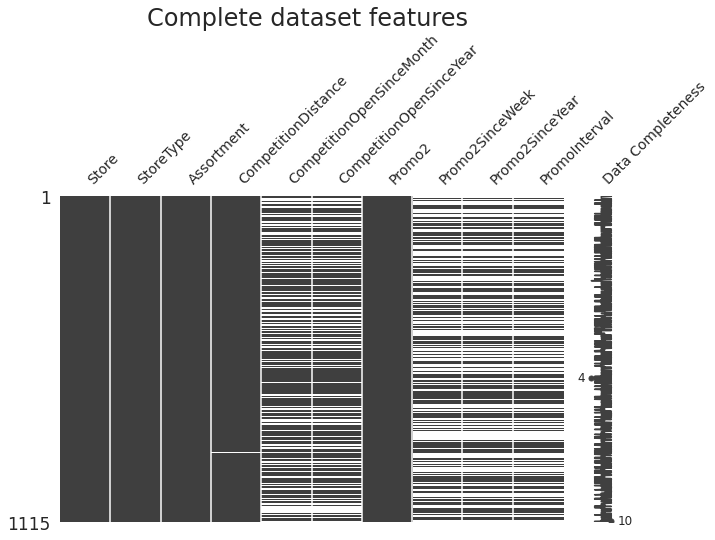

In [25]:
# visualize missing value matrix for the complete dataset
msno.matrix(rossman_stores, labels=True, fontsize=14, figsize=(10,6))
plt.title("Complete dataset features ", fontsize=24)
plt.show()

As we can see, the Store dataset has more missing values than the Train dataset.

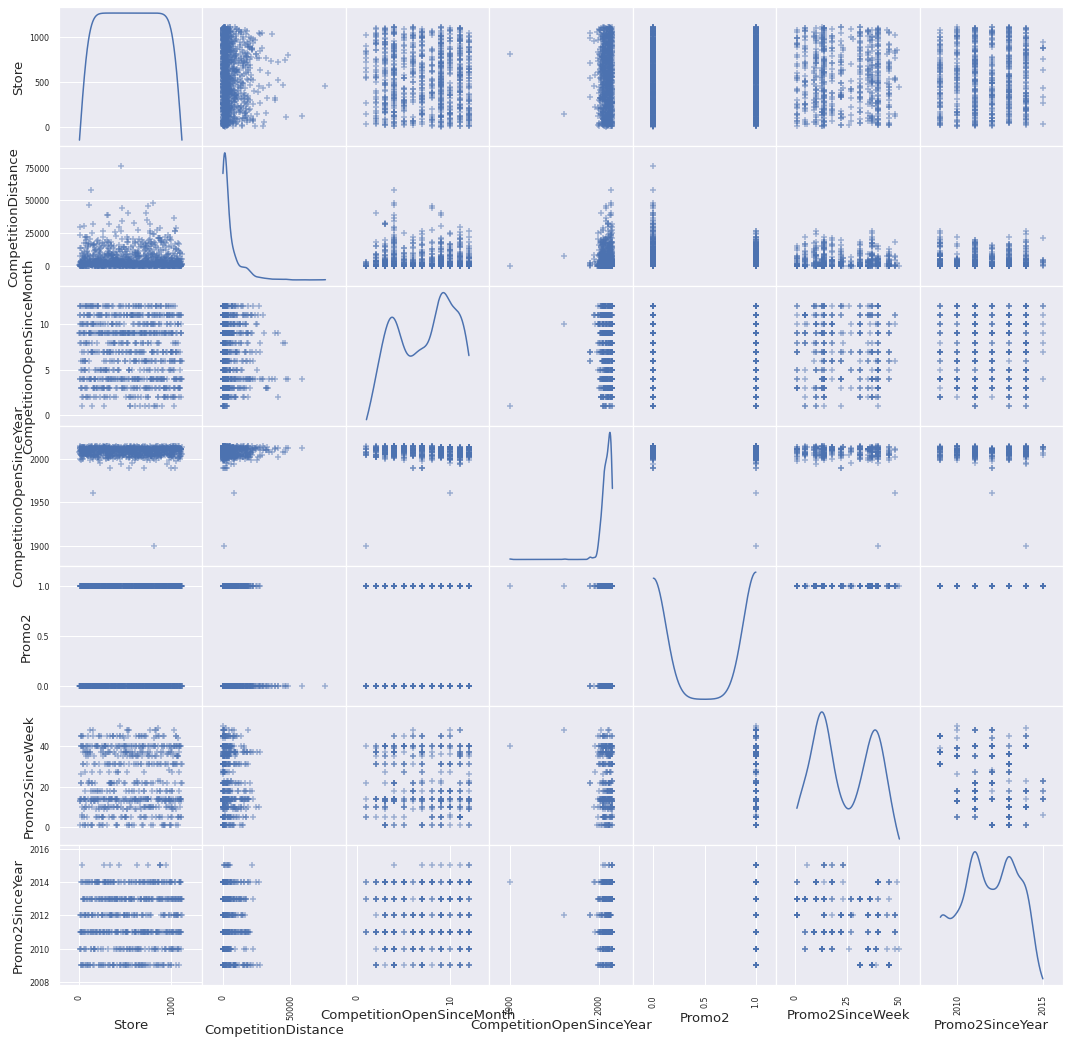

In [26]:
# visualize the dataset
plt.style.use('seaborn-deep')
scatter_matrix(rossman_stores, diagonal='kde', range_padding=0.4, marker='+', figsize=(18,18))
plt.show()

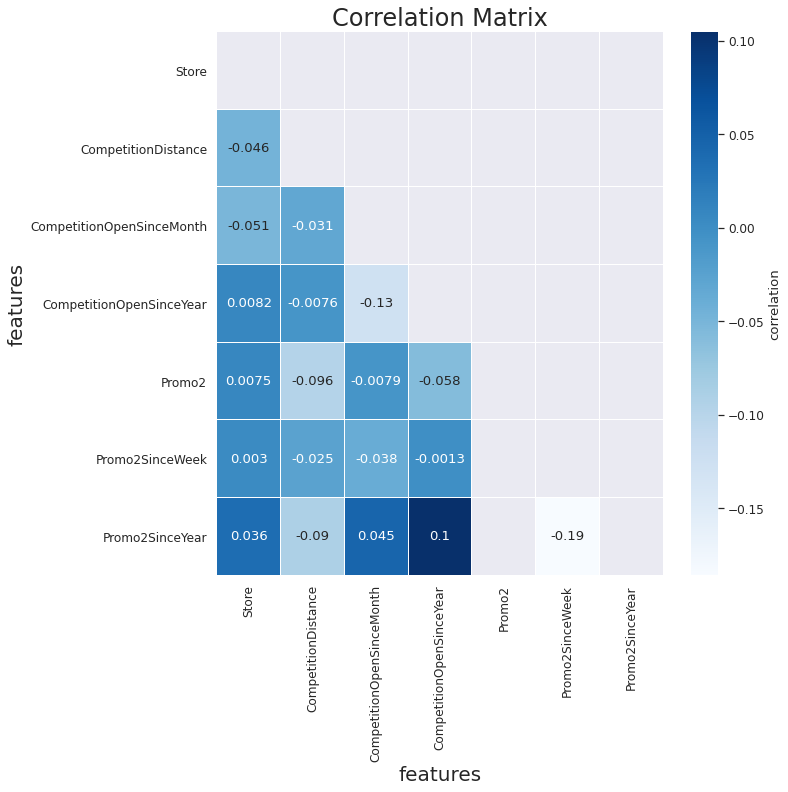

In [27]:
# Correlation matrix completely ignores any non-numeric column. 
fig, ax = plt.subplots(figsize=(10,10))

matrix = np.triu(rossman_stores.corr('spearman'))
sns.set(font_scale=1.1)
sns.heatmap(rossman_stores.corr(method='spearman'), linewidth= 0.1, annot=True, cmap='Blues', cbar_kws={'label': 'correlation'}, mask=matrix)
plt.xlabel("features", size=20)
plt.ylabel("features", size=20)
plt.title("Correlation Matrix", size=24)
plt.show()

## Merging train and stores datasets

Let's put everything together.

In [28]:
# merging both data files
rossman_train['Store'] = rossman_train['Store'].fillna(0)
rossman_train['Store'] = rossman_train['Store'].astype(int)
#rossman_merged = pd.merge(rossman_train, rossman_stores, on="Store", how='left') # Stores with nan values are included
rossman_merged = pd.merge(rossman_train, rossman_stores, on="Store") 

In [29]:
# show firts lines of the merged dataset
rossman_merged.head()

,Date,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,2013-01-01,1115,2.0,0.0,0.0,0.0,0.0,a,1.0,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1,2013-01-02,1115,3.0,3697.0,305.0,1.0,0.0,0,1.0,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
2,2013-01-03,1115,4.0,4297.0,300.0,1.0,0.0,0,1.0,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
3,2013-01-04,1115,5.0,4540.0,326.0,1.0,0.0,0,1.0,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
4,2013-01-05,1115,6.0,4771.0,339.0,1.0,0.0,0,1.0,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"


In [30]:
# dimensions
rossman_merged.shape

(618473, 18)

In [31]:
# total number of null values if they are present
print('Features with missing values:\n')
rossman_merged.isnull().sum()[rossman_merged.isnull().sum() > 0]

Features with missing values:



DayOfWeek                     18437
Sales                         18445
Customers                     18516
Open                          18641
Promo                         18682
StateHoliday                  18600
SchoolHoliday                 18787
CompetitionDistance            1635
CompetitionOpenSinceMonth    196430
CompetitionOpenSinceYear     196430
Promo2SinceWeek              303645
Promo2SinceYear              303645
PromoInterval                303645
dtype: int64

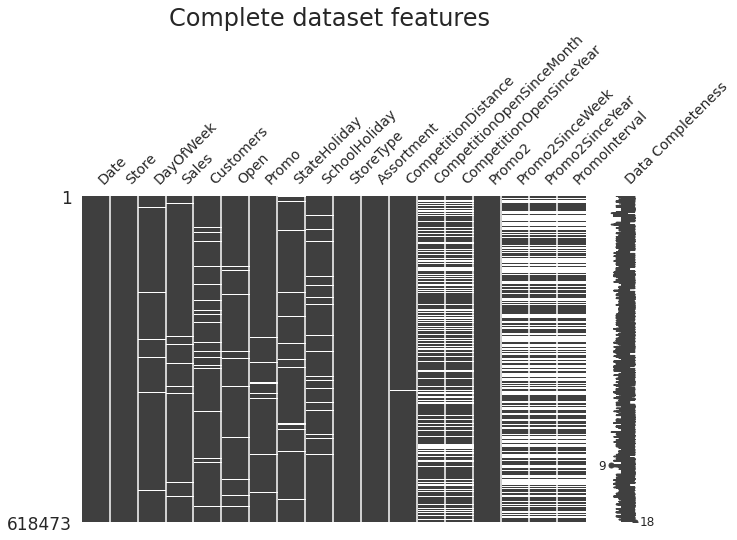

In [32]:
# visualize missing value matrix for the complete dataset
msno.matrix(rossman_merged, labels=True, fontsize=14, figsize=(10,6))
plt.title("Complete dataset features ", fontsize=24)
plt.show()

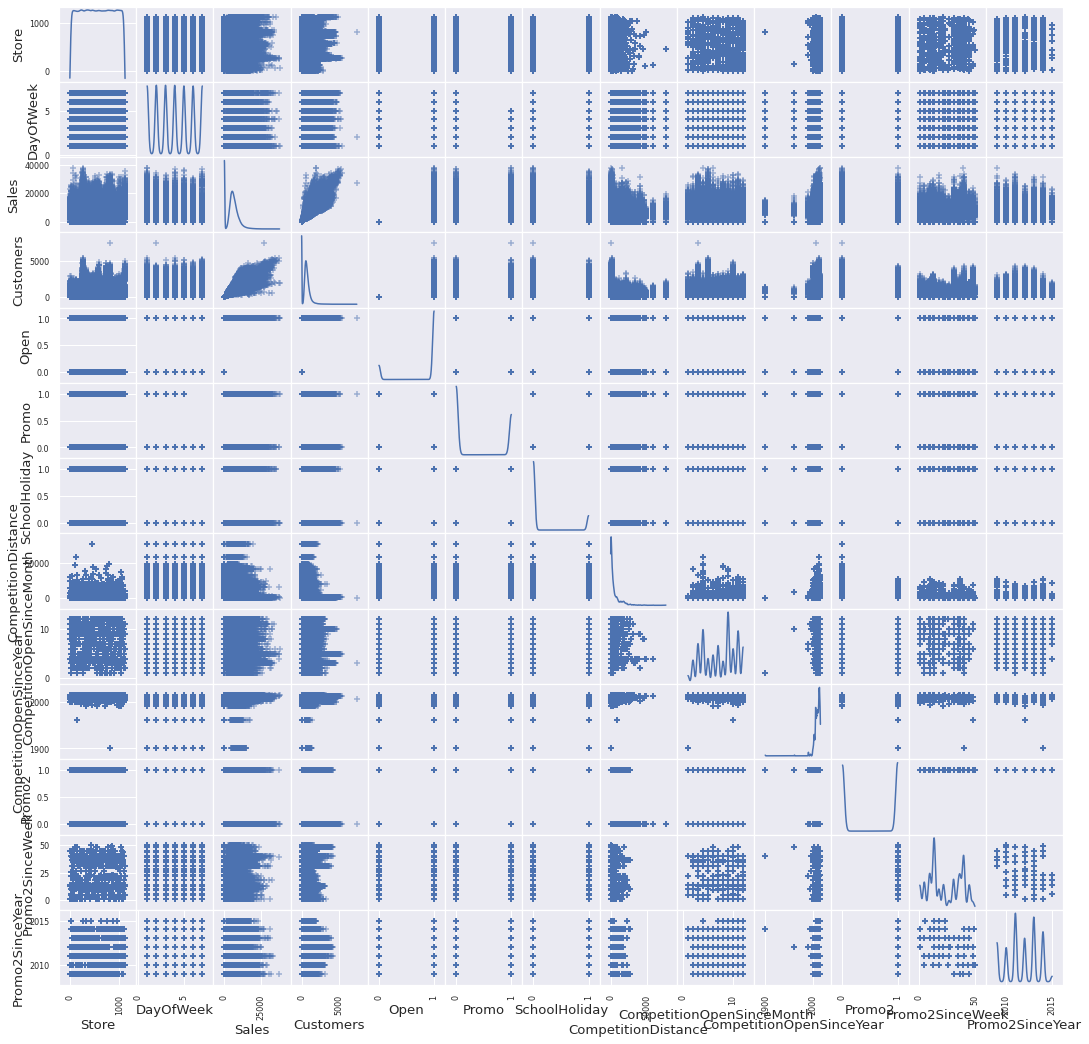

In [33]:
# visualize the dataset
plt.style.use('seaborn-deep')
scatter_matrix(rossman_merged, diagonal='kde', range_padding=0.4, marker='+', figsize=(18,18))

plt.show()

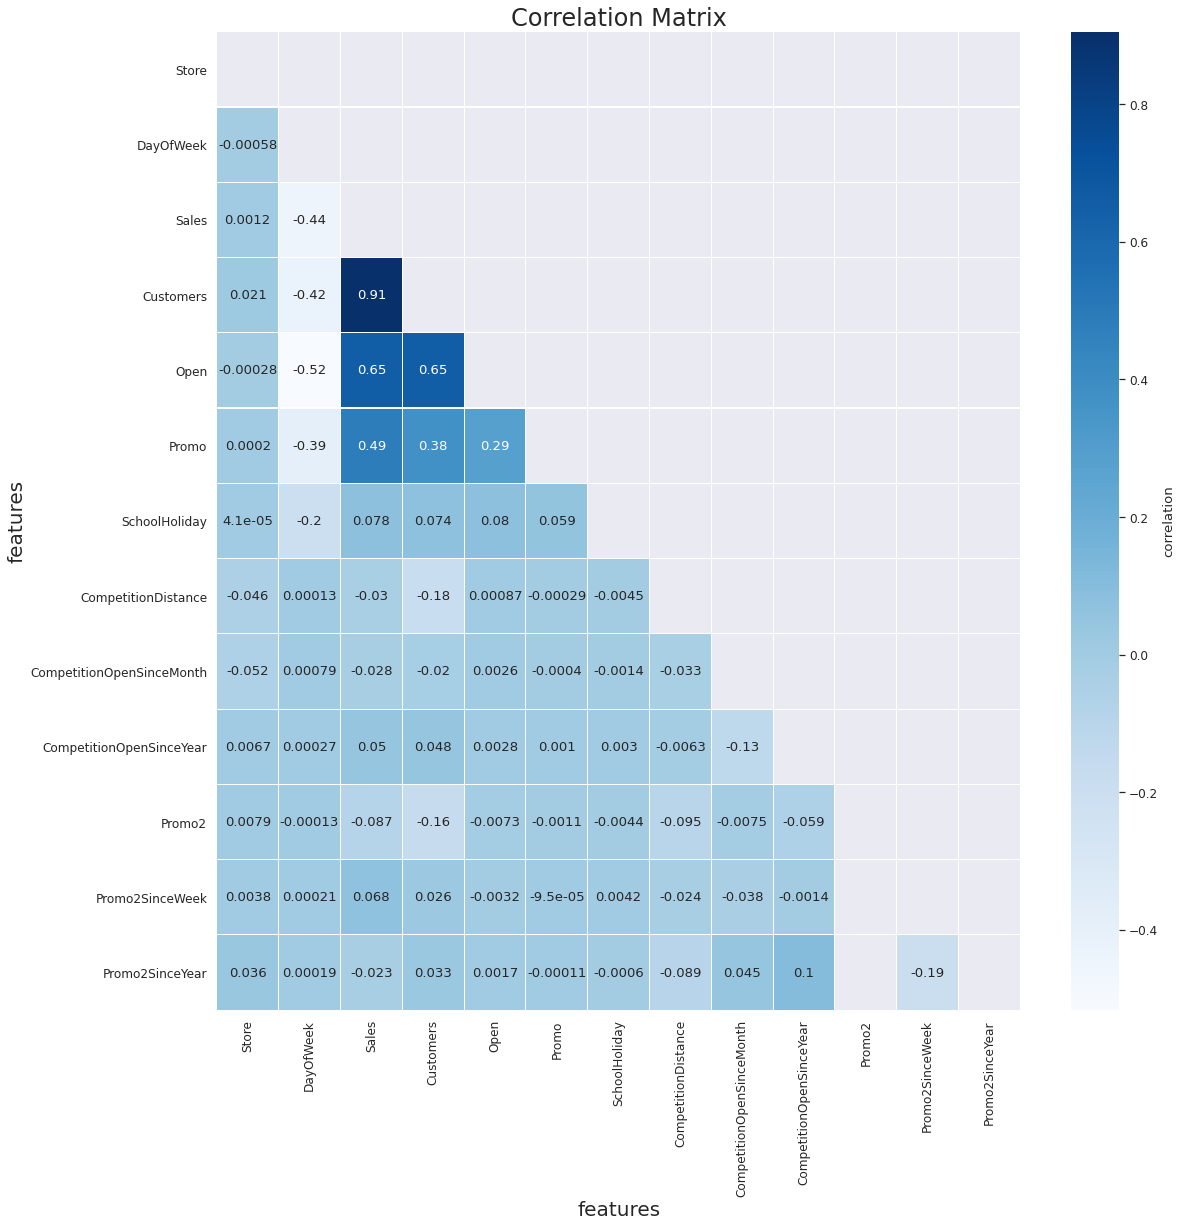

In [34]:
# Correlation matrix completely ignores any non-numeric column. 
fig, ax = plt.subplots(figsize=(18, 18))

matrix = np.triu(rossman_merged.corr('spearman'))
sns.set(font_scale=1.1)
sns.heatmap(rossman_merged.corr(method='spearman'), linewidth= 0.1, annot=True, cmap='Blues', cbar_kws={'label': 'correlation'}, mask=matrix)
plt.xlabel("features", size=20)
plt.ylabel("features", size=20)
plt.title("Correlation Matrix", size=24)
plt.show()

From the above plot we can see that exist some positive correlation between the features:
* Customers and Sales
* Open and Sales
* Open and Customers
* Promo and Sales
* Promo and Customers
* Promo and Open